In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import json 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import files
uploaded=files.upload()

Saving intents.json to intents.json


In [6]:
with open('intents.json') as file:
    data = json.load(file)
    
data

{'intents': [{'context_set': '',
   'patterns': ['Hi',
    'How are you',
    'Is anyone there?',
    'Hello',
    'Good day',
    'Hey'],
   'responses': ['Hello, thanks for visiting',
    'Good to see you again',
    'Hi there, how can I help?'],
   'tag': 'greeting'},
  {'patterns': ['Bye', 'See you later', 'Goodbye', 'okay bye', 'exit'],
   'responses': ['See you later, thanks for visiting',
    'Have a nice day',
    'Bye! Come back again soon.'],
   'tag': 'goodbye'},
  {'patterns': ['Who are you',
    'What are you',
    'What is your name ',
    'what should I call you',
    'whats your name?'],
   'responses': ['I am JARVIS',
    'My name is JARVIS and I am your virtual assistant'],
   'tag': 'about'},
  {'patterns': [],
   'responses': ["Sorry, can't understand you",
    'Please give me more info',
    'Not sure I understand'],
   'tag': 'noanswer'},
  {'patterns': ['Thanks', 'Thank you', "That's helpful", 'okay'],
   'responses': ['Happy to help!', 'Any time!', 'My pleasure'

In [7]:
training_sentences = []
training_labels = []
labels = []
responses = []


for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(pattern)
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])
    
    if intent['tag'] not in labels:
        labels.append(intent['tag'])
        
num_classes = len(labels)

In [8]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(training_labels)
training_labels = lbl_encoder.transform(training_labels)

In [9]:
vocab_size = 1000
embedding_dim = 20
max_len = 20
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)


In [10]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 20)            20000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
Total params: 21,260
Trainable params: 21,260
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(padded_sequences, np.array(training_labels), epochs=1000, batch_size=128)

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 2.9953 - accuracy: 0.0256
Epoch 2/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.9940 - accuracy: 0.1026
Epoch 3/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.9928 - accuracy: 0.1026
Epoch 4/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.9917 - accuracy: 0.1026
Epoch 5/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.9908 - accuracy: 0.1026
Epoch 6/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.9898 - accuracy: 0.1026
Epoch 7/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.9889 - accuracy: 0.1026
Epoch 8/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.9879 - accuracy: 0.1026
Epoch 9/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.9869 - accuracy: 0.1026
Epoch 10/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.9859 - accuracy: 0.1026
Epoch 11/1000
1/1 [=

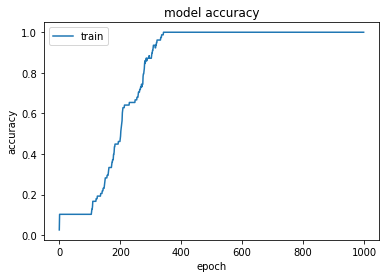

accuracy: 80.58%


In [12]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

acc = np.mean(history.history['accuracy'])
print("%s: %.2f%%" % ('accuracy',(acc*100)))

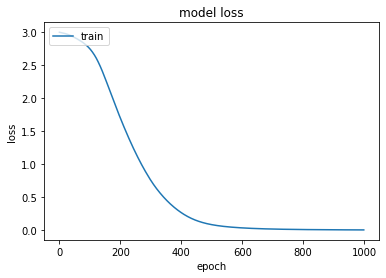

loss: 71.20%


In [13]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

loss = np.mean(history.history['loss'])
print("%s: %.2f%%" % ('loss',(loss*100)))

In [14]:
# to save the trained model
model.save("chat_model")

import pickle

# to save the fitted tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to save the fitted label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: chat_model/assets


In [15]:
!pip install colorama

In [20]:
import json 
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

import colorama 
colorama.init()
from colorama import Fore, Style, Back

import random
import pickle

with open("intents.json") as file:
    data = json.load(file)


def chat():
    # load trained model
    model = keras.models.load_model('chat_model')

    # load tokenizer object
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # load label encoder object
    with open('label_encoder.pickle', 'rb') as enc:
        lbl_encoder = pickle.load(enc)

    # parameters
    max_len = 20
    
    while True:
        print(Fore.LIGHTBLUE_EX + "User: " + Style.RESET_ALL, end="")
        inp = input()
        if inp.lower() == "quit":
            break

        result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                             truncating='post', maxlen=max_len))
        results_index = np.argmax(result)
        tag = lbl_encoder.inverse_transform([np.argmax(result)])
        print("Confidence Score : ",result[0][results_index])
        if result[0][results_index]>0.7:

          for i in data['intents']:
              if i['tag'] == tag:
                  print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL , np.random.choice(i['responses']))
        else:
          print("Out of context. Ask again!!")          

        # print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL,random.choice(responses))

print(Fore.YELLOW + "Start messaging with the bot (type quit to stop)!" + Style.RESET_ALL)

Start messaging with the bot (type quit to stop)!


In [22]:
chat()

User: hello
Confidence Score :  0.9962656
ChatBot: Hello, thanks for visiting
User: who are you
Confidence Score :  0.99474525
ChatBot: I am JARVIS
User: what is your menu
Confidence Score :  0.9958513
ChatBot: You can check various delicacies given in the food menu at www.mymenu.com
User: what is your location
Confidence Score :  0.9969363
ChatBot: Our Address is: Stark Restaurant Saket, New Delhi - 110017, India
User: okay thanks
Confidence Score :  0.9996313
ChatBot: Any time!
User: good to talk to you
Confidence Score :  0.8686913
ChatBot: Hi there, how can I help?
User: okay bye
Confidence Score :  0.99618214
ChatBot: See you later, thanks for visiting
User: quit
